## Final Project: Developing a Bernoulli Binary Bandit Ticker Picker Agent, then Assess Performance using Minimum Variance Allocation Condition
In this project, a collection of agents were developed to advise us which stocks we should include in a portfolio $\mathcal{P}$ by solving a Multi-arm Binary Bandit problem using [ϵ-Greedy Thompson Sampling](https://arxiv.org/abs/1707.02038). The `K`-actions (bandits) are the potential `tickers` in the portfolio $\mathcal{P}$ portfolio. After their analysis, we'll ask the agents to rank-order their preferred `tickers`. 

### Problem
* `N` agents independently analyzing daily Open High Low Close (OHLC) data sequences and rank-ordering their belief that the ticker `XYZ` will return at least the risk-free rate in the next step. 
* The `world` is then sampled. If the ticker `XYZ` returns greater than or equal to the risk-free rate in the sample period, the agent receives a reward of `+1`. Otherwise, the agent receives a reward of `0`.
* Each agent develops a distribution of beliefs for the probability $p_{a}$, i.e., the probability that `ticker` will beat the risk-free rate based on this experimentation. These beliefs are encoded in the parameters of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760\5760-Final-Project-check\CHEME-5760-Final-Project\Project.toml`
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760\5760-Final-Project-check\CHEME-5760-Final-Project\Manifest.toml`
  Activating project at `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760\5760-Final-Project-check\CHEME-5760-Final-Project`
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760\5760-Final-Project-check\CHEME-5760-Final-Project\Project.toml`
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760\5760-Final-Project-check\CHEME-5760-Final-Project\Manifest.toml`
    Updating registry at `C:\Users\Lillian K\.julia\registries\General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\CHEME 5760

In [2]:
include(joinpath(_PATH_TO_SRC, "CHEME-5660-L14a-BanditProblems-CodeLibrary.jl"));

## Prerequisites: Load and clean the historical dataset
A daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-17-2023` is gathered, along with data for a few exchange traded funds and volatility products during that time. 

In [3]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-11-17-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Only those tickers with the maximum number of trading days were collected.

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

1480

Iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

A list of firms that we have in cleaned up `dataset` saved in the `all_tickers` array:

In [6]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers)

459

## Initialize the `world` function
The world function takes action `a`, i.e., chooses a `ticker` from the collection of stocks/ETFs that we are exploring, and asks whether or not the return of this `ticker` at the end of today was greater or equal to the risk-free rate. 
* If the daily return is greater than or equal to the risk-free rate, the `agent` receives a reward of `r = 1`. Otherwise, the `agent` receives a `r = 0` reward.

In [7]:
function world(action::Int64, start::Int64, data::Dict{String, DataFrame}, tickers::Array{String,1}; 
        Δt::Float64 = (1.0/252.0), risk_free_rate::Float64 = 0.05, buffersize::Int64 = 1)::Int64

    # initialize -
    result_flag = 0;

    # daily risk free rate -
    T = buffersize*Δt;

    # grab the ticker we are looking at?
    ticker_symbol = tickers[action];
    
    # compute the expected return over the horizon -
    price_df = data[ticker_symbol];
    time = range(start+1,(start+buffersize), step=1) |> collect
    buffer = Array{Float64,1}();
    for t ∈ time
        P₁ = price_df[t-1,  :volume_weighted_average_price]
        P₂ = price_df[t, :volume_weighted_average_price]
        R = (1/Δt)*log(P₂/P₁);
        push!(buffer,R);
    end
    μ = mean(buffer);

    # if we invested 1 USD, in each how much would we have at the end of horizon -
    W_risk_free = exp(risk_free_rate*T);
    W_ticker = exp(μ*T);
    
    # are we better or worse relative to the risk-free investment?
    if (W_ticker >= W_risk_free)
        result_flag = 1;
    end

    # default -
    return result_flag;
end;

Set the `risk_free_rate` variable:

In [8]:
risk_free_rate = 0.047;

## Setup the `ticker-picker` agent

The 25 tickers examined in the `tickers` array are randomly selected, and store the number of tickers in the `K` variable:

In [9]:
all_tickers

459-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBH"
 "ZBRA"
 "ZION"
 "ZTS"

In [10]:
tickers = ["AMD","AEP","CRL","MET","ECL","TSLA","FIS","MSFT","OKE","DIS","JPM","C","MRK","PEP","V","CZR","TMUS","AAPL","TXT","INTC","IT","URI","VRTX","IVZ","BSX"];
K = length(tickers);

The `EpsilonSamplingModel` instance is constructed which holds information about the ϵ-greedy sampling approach. The `EpsilonSamplingModel` type has one additional field, the `ϵ` field which controls the approximate fraction of `exploration` steps the algorithm takes; `exploration` steps are purely random.

In [11]:
model = EpsilonSamplingModel()
model.K = K; # tickers
model.α = ones(K); # initialize to uniform values
model.β = ones(K); # initialize to uniform values
model.ϵ = 0.3;

## Run a single `ticker-picker` agent and explore its preferences
A single `ticker-picker` agent is tested and examined what it returns using the `sample(...)` function. 

In [12]:
time_sample_results_dict_eps = sample(model, world, dataset, tickers; 
    horizon = (maximum_number_trading_days - 1), risk_free_rate = risk_free_rate)

Dict{Int64, Matrix{Float64}} with 1479 entries:
  1144 => [37.0 25.0; 31.0 27.0; … ; 8.0 9.0; 41.0 28.0]
  1175 => [40.0 25.0; 31.0 27.0; … ; 8.0 11.0; 42.0 29.0]
  719  => [24.0 16.0; 31.0 21.0; … ; 2.0 6.0; 22.0 14.0]
  1028 => [34.0 22.0; 31.0 27.0; … ; 5.0 7.0; 35.0 18.0]
  699  => [23.0 16.0; 31.0 21.0; … ; 2.0 6.0; 22.0 14.0]
  831  => [29.0 18.0; 31.0 24.0; … ; 2.0 6.0; 26.0 16.0]
  1299 => [50.0 32.0; 31.0 27.0; … ; 8.0 12.0; 53.0 30.0]
  1438 => [53.0 34.0; 31.0 28.0; … ; 9.0 12.0; 60.0 37.0]
  1074 => [34.0 23.0; 31.0 27.0; … ; 7.0 8.0; 39.0 22.0]
  319  => [9.0 7.0; 17.0 7.0; … ; 2.0 3.0; 14.0 8.0]
  687  => [23.0 16.0; 31.0 21.0; … ; 2.0 6.0; 21.0 14.0]
  1199 => [44.0 26.0; 31.0 27.0; … ; 8.0 11.0; 42.0 29.0]
  185  => [8.0 5.0; 4.0 4.0; … ; 2.0 3.0; 10.0 6.0]
  823  => [29.0 18.0; 31.0 24.0; … ; 2.0 6.0; 26.0 16.0]
  1090 => [34.0 24.0; 31.0 27.0; … ; 7.0 8.0; 40.0 23.0]
  420  => [11.0 8.0; 27.0 10.0; … ; 2.0 4.0; 16.0 11.0]
  1370 => [51.0 33.0; 31.0 28.0; … ; 9.0 12.0;

In [13]:
Z = time_sample_results_dict_eps[1479]

25×2 Matrix{Float64}:
 54.0  36.0
 31.0  28.0
  4.0   9.0
  3.0   8.0
 21.0  19.0
 17.0  18.0
 33.0  25.0
 41.0  31.0
 21.0  21.0
 13.0  15.0
 10.0  10.0
 23.0  22.0
  9.0  11.0
  8.0   9.0
  4.0   8.0
 41.0  32.0
 12.0  14.0
 93.0  54.0
 24.0  21.0
 13.0  12.0
 10.0  12.0
 19.0  19.0
 16.0  14.0
  9.0  12.0
 60.0  40.0

## Run a collection of `ticker-picker` agents and examine their preferences
The single-agent analysis is repeated with `N` agents by running the `sample(...)` method inside a `for` loop. The results of the last time point are stored in the `agent_specific_data::Array{Beta,2}(undef, K, number_of_agents)` array. 
* The `agent_specific_data` array holds the `Beta` distributions for each agent, i.e., it holds the preferences for each agent (cols) for each `ticker` in our collection (rows).

In [14]:
number_of_agents = 10000;
trading_day_index = 1400
agent_specific_data = Array{Beta,2}(undef, K, number_of_agents);

for agent_index ∈ 1:number_of_agents
    
    # sample -
    time_sample_results_dict_eps = sample(model, world, dataset, tickers; horizon = (maximum_number_trading_days - 1), risk_free_rate = risk_free_rate);
    beta_array = build_beta_array(time_sample_results_dict_eps[trading_day_index]);

    # grab data for this agent -
    for k = 1:K
        agent_specific_data[k, agent_index] = beta_array[k]
    end
end

In [15]:
agent_specific_data[1,:] # data for each agent for ticker 1 for all the agents

10000-element Vector{Beta}:
 Beta{Float64}(α=41.0, β=34.0)
 Beta{Float64}(α=20.0, β=21.0)
 Beta{Float64}(α=15.0, β=17.0)
 Beta{Float64}(α=1.0, β=6.0)
 Beta{Float64}(α=35.0, β=27.0)
 Beta{Float64}(α=13.0, β=17.0)
 Beta{Float64}(α=55.0, β=39.0)
 Beta{Float64}(α=69.0, β=56.0)
 Beta{Float64}(α=8.0, β=13.0)
 Beta{Float64}(α=2.0, β=6.0)
 Beta{Float64}(α=24.0, β=20.0)
 Beta{Float64}(α=29.0, β=26.0)
 Beta{Float64}(α=8.0, β=9.0)
 ⋮
 Beta{Float64}(α=33.0, β=28.0)
 Beta{Float64}(α=22.0, β=22.0)
 Beta{Float64}(α=5.0, β=9.0)
 Beta{Float64}(α=13.0, β=18.0)
 Beta{Float64}(α=57.0, β=37.0)
 Beta{Float64}(α=66.0, β=51.0)
 Beta{Float64}(α=18.0, β=20.0)
 Beta{Float64}(α=26.0, β=23.0)
 Beta{Float64}(α=5.0, β=10.0)
 Beta{Float64}(α=11.0, β=13.0)
 Beta{Float64}(α=26.0, β=22.0)
 Beta{Float64}(α=36.0, β=29.0)

## Evaluate Collective Preferences as a whole
Now that we have prefernces for the `N` agents (encoded as `Beta` distributions for each ticker), let's develop a concencous belief in which tickers to include in our portfolio $\mathcal{P}$. First, let's compute the agent-specific rank of eack ticker, where `rank = 1` is the best, and `rank = K` is the worst. We'll store these values in the `preference_rank_array` array.

In [16]:
preference_rank_array = Array{Int,2}(undef, number_of_agents, K);
for agent ∈ 1:number_of_agents
        
    # ask agent about thier preference for ticker i -
    experience_distributions = agent_specific_data[:,agent]
    preference_vector = preference(experience_distributions, tickers) .|> x-> trunc(Int64,x) # trunc function is cool!
    
    # package -
    for i ∈ 1:K
        preference_rank_array[agent, i] = preference_vector[i];
    end
end
preference_rank_array

10000×25 Matrix{Int64}:
  7  16  13   4  22   1   8  15   5  …  24  13   6  25  22   9  10  21   3
 10  24  23   1  14  24   9   7   3     11  21  20   4  12  21  18  15   5
 17   2   3  24  10  20   1   6   7      9  12   5   4  21  16  11   8  15
 25  24   8  17   9   5  16  10   2     18   1  13  21  19  11  15  12   6
  6  15  25  15   7   9   8  23  19     10  12  18   2   4   5   1  13  17
 13  17  20   3   6  18   4   7  14  …   8  10   1  19  21  23  21  24  11
  1   3  23  17   9  25   2   6   5      8  22  12  24  18  15  21  15  13
  2  21  19   7  16  23  10   3  14     21  12   5  15  18   8  21   6  25
 23  20   6  22   7  17   3   2  24     25  19   4   9   8  16  21  18   1
 24  15  11  22  16  22   7   3   2     14  25   4  16   6  21  18  12   1
  9   1   6  13  18   5   8  24  10  …   7  14  11  21  15  20  15  22  12
  7   3  23   1  11  20  13  15  15      5  18  24  17   8  22   9  11   5
 15  20   9   3  23  23  20   1   7     18  11   8   2  16  22  10  18  13
 

### Compute the frequency dictionary
The times a `ticker` is ranked in the `top 3` across the `N` agents are calculated, and then normalized by the number of agents, i.e., compute the frequency of being ranked in the `top 3`. this value is stored in the `frequency_dictionary,` where the `ticker` is the key, and the frequency is the value.

In [17]:
frequency_dictionary = Dict{String,Float64}();
for i ∈ eachindex(tickers)
    
    # compute the frequency -
    freq = findall(x-> x ≤ 8, preference_rank_array[:,i]) |> x-> length(x) |> x-> x/number_of_agents
    
    # get the ticker -
    ticker = tickers[i];
    frequency_dictionary[ticker] = freq;
end

In [18]:
frequency_dictionary

Dict{String, Float64} with 25 entries:
  "MSFT" => 0.4629
  "JPM"  => 0.3231
  "AEP"  => 0.3533
  "C"    => 0.2196
  "MRK"  => 0.2968
  "V"    => 0.3301
  "TMUS" => 0.2529
  "OKE"  => 0.4518
  "CRL"  => 0.3808
  "TSLA" => 0.348
  "CZR"  => 0.3641
  "VRTX" => 0.3634
  "AMD"  => 0.3218
  "BSX"  => 0.3668
  "TXT"  => 0.2649
  "INTC" => 0.2375
  "IVZ"  => 0.2756
  "IT"   => 0.3618
  "DIS"  => 0.1656
  "ECL"  => 0.2825
  "URI"  => 0.2882
  "FIS"  => 0.2614
  "PEP"  => 0.3353
  "MET"  => 0.3472
  "AAPL" => 0.3897

### Gather top 6 tickers
Based on the frequency of a ticker being in the top 3 preferred, the top 6 tickers are selected to create a portfolio. The distribution of stock are chosed based on an efficient frontier. Then the net present value of the portfolio is calculated and compared against a benchmark.

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used are calculated

In [19]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate);

In [20]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

In [21]:
sims = load(joinpath(_PATH_TO_DATA, "SIM-SP500-01-03-18-to-10-31-23.jld2")) |> x->x["sim"];

In [22]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
R_SPY = μ[index_SPY]

0.040264757315225844

In [23]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(all_tickers)
    
    myticker = all_tickers[i];
    sim = sims[myticker];
    
    αᵢ = sim.α
    βᵢ = sim.β
    Rᵢ = αᵢ+βᵢ*R_SPY
    
    push!(μ_sim,Rᵢ)
end

In [24]:
σₘ = std(all_firms_excess_return_matrix[:, index_SPY]);

In [25]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

In [26]:
𝒟(r,t) = exp(r*t);

In [27]:
my_list_of_tickers = ["MSFT", "OKE","BSX","V","FIS","AEP"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

The firm-specific expected return vector and covariance matrix are calculated.

In [49]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

In [50]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [51]:
my_data = Dict{String,Any}();
my_data["expected_excess_return"] = μ̂_sim;
my_data["covariance"] = Σ̂_sim;
save(joinpath(_PATH_TO_DATA,"MyChoiceSet-Example.jld2"), Dict("dataset" => my_data));

In [52]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
number_of_points = 40;

In [53]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, An array with the minimum desired rewards (the calculation must achieve at least this much reward) is created:

In [54]:
minimum_desired_reward_array = range(0.0, stop = 0.5 - risk_free_rate, length = number_of_points) |> collect;

Tthe `minimum_desired_reward_array` is iterated and the minimum risk required to achieve the specified reward level is calculated using a `for-loop`. In particular, in each pass through the loop, 
* Update the `problem_risk` variable with the minimum desired reward
* Pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* Check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [56]:
efficient_frontier_sim = Dict{Float64,Float64}();
portfolio_df = DataFrame();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_sim["objective_value"]);
        value = solution_sim["reward"];
        efficient_frontier_sim[key] = value;
        
        w_opt = solution_sim["argmax"];
        
        # add data to portfolio_df -
        row_df = (
            expected_excess_return = value,
            risk = key,
            tickers = my_list_of_tickers,
            w = w_opt,
            risk_free_rate = risk_free_rate
        )
        push!(portfolio_df,row_df);
    end
end
efficient_frontier_sim

Dict{Float64, Float64} with 18 entries:
  0.169663 => 0.0340908
  0.184631 => 0.116154
  0.169663 => 0.0340907
  0.216726 => 0.174231
  0.209187 => 0.162615
  0.233924 => 0.197462
  0.171746 => 0.0696923
  0.173691 => 0.0813077
  0.224753 => 0.185846
  0.169664 => 0.0348513
  0.176516 => 0.0929231
  0.195676 => 0.139385
  0.169912 => 0.0464618
  0.189816 => 0.127769
  0.202152 => 0.151
  0.170599 => 0.058077
  0.169663 => 0.0340907
  0.180179 => 0.104538

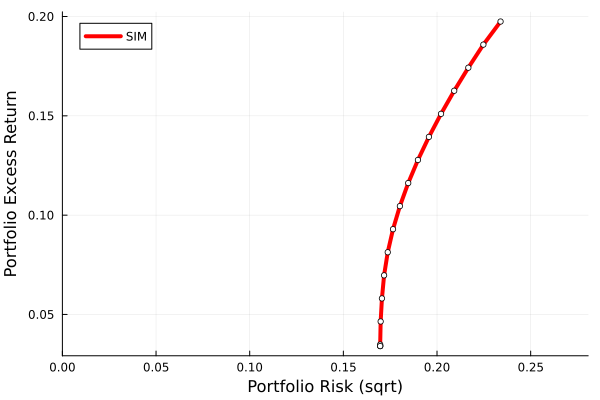

In [57]:
# single index model -
plot(efficient_frontier_sim, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Excess Return", fontsize=18, label="SIM", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_sim).first))
scatter!(efficient_frontier_sim, label="", c=:white, mec=:red, ms=3)

In [58]:
filepath = joinpath(_PATH_TO_DATA, "EfficientFrontier-Example.jld2");
save(filepath, Dict("dataset"=>portfolio_df))

## Evaluate the performance of the `SIM` portfolio


In [59]:
Wₒ = 2500;
number_of_trading_days = 120;
offset = 1;

In [63]:
P = rand(efficient_frontier_sim);
P
σₚ = 0.23392395178745523
μₚ = efficient_frontier_sim[σₚ]



0.19746152871429365

In [64]:
keys(efficient_frontier_sim)

KeySet for a Dict{Float64, Float64} with 18 entries. Keys:
  0.16966285811823276
  0.18463118418965724
  0.16966285810525203
  0.21672630160539028
  0.20918690085230207
  0.23392395178745523
  0.1717456416123018
  0.1736908068157572
  0.22475313404430539
  0.16966380231962333
  0.1765157571648965
  0.19567605540574412
  0.16991248952682722
  0.18981621652578076
  0.20215201301647737
  0.17059940911811278
  0.16966285100920805
  0.1801792293667372

In [65]:
wealth_array = Array{Float64,2}(undef, number_of_trading_days, 8);
for i ∈ 1:number_of_trading_days
    Δt = (i-1)*(1/252);
    
    wealth_array[i,1] = Δt
    wealth_array[i,2] = Wₒ*exp((μₚ + risk_free_rate)*Δt);
    wealth_array[i,3] = Wₒ*exp((μₚ - σₚ + risk_free_rate)*Δt);
    wealth_array[i,4] = Wₒ*exp((μₚ + σₚ + risk_free_rate)*Δt);
    wealth_array[i,5] = Wₒ*exp((μₚ - 1.96*σₚ + risk_free_rate)*Δt);
    wealth_array[i,6] = Wₒ*exp((μₚ + 1.96*σₚ + risk_free_rate)*Δt);
    wealth_array[i,7] = Wₒ*exp((μₚ - 2.576*σₚ + risk_free_rate)*Δt);
    wealth_array[i,8] = Wₒ*exp((μₚ + 2.576*σₚ + risk_free_rate)*Δt);
end

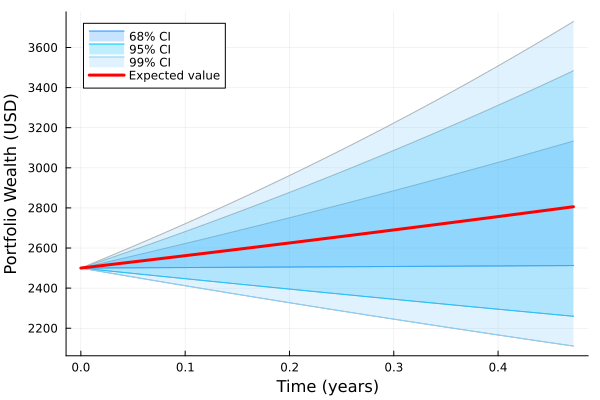

In [66]:
p = plot();
plot!(wealth_array[:,1],wealth_array[:,3],lw=1,label="",c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,4],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,5],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,6],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,7],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,8],lw=1,label="", c=:gray69)

L68 = wealth_array[:,3];
U68 = wealth_array[:,4];
plot!(wealth_array[:,1], L68, fillrange = U68, fillalpha = 0.25, c = :dodgerblue, label = "68% CI")

L95 = wealth_array[:,5];
U95 = wealth_array[:,6];
plot!(wealth_array[:,1], L95, fillrange = U95, fillalpha = 0.25, c = :deepskyblue, label = "95% CI")

L99 = wealth_array[:,7];
U99 = wealth_array[:,8];
plot!(wealth_array[:,1], L99, fillrange = U99, fillalpha = 0.25, c = :lightskyblue, label = "99% CI")

plot!(wealth_array[:,1],wealth_array[:,2],lw=3,label="Expected value", c=:red)
xlabel!("Time (years)", fontsize=18)
ylabel!("Portfolio Wealth (USD)", fontsize=18)

In [67]:
WFP = wealth_array[end,2] |> x-> round(x,digits=2);
WFP_LB = wealth_array[end,3] |> x-> round(x,digits=2)
WFP_UB = wealth_array[end,4] |> x-> round(x,digits=2)
println("The selected portfolio should be worth (L,E,U) = ($(WFP_LB), $(WFP), $(WFP_UB)) USD")

The selected portfolio should be worth (L,E,U) = (2512.47, 2805.92, 3133.64) USD


In [68]:
Δt = (number_of_trading_days/252);
NPV_P = -Wₒ + (1/𝒟(risk_free_rate, Δt))*WFP
println("The expected NPV for this portfolio is NPV = $(NPV_P)")

The expected NPV for this portfolio is NPV = 243.8183770680298


In [69]:
σ̄ₘ = σₘ*sqrt(1/252) # correct for annualized std dev
wealth_array_SPY = Array{Float64,2}(undef, number_of_trading_days, 8);
for i ∈ 1:number_of_trading_days
    Δt = (i-1)*(1/252);
    
    wealth_array_SPY[i,1] = Δt
    wealth_array_SPY[i,2] = Wₒ*exp((R_SPY + risk_free_rate)*Δt);
    wealth_array_SPY[i,3] = Wₒ*exp((R_SPY - σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,4] = Wₒ*exp((R_SPY + σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,5] = Wₒ*exp((R_SPY - 1.96*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,6] = Wₒ*exp((R_SPY + 1.96*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,7] = Wₒ*exp((R_SPY - 2.576*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,8] = Wₒ*exp((R_SPY + 2.576*σ̄ₘ + risk_free_rate)*Δt);
end

In [70]:
SPY_actual = Array{Float64,2}(undef, number_of_trading_days, 2);
SPY_data = dataset["SPY"];
SPY_return = Array{Float64,1}(undef, number_of_trading_days);
for j ∈ 2:number_of_trading_days+1
    date_index = (j - 1) + offset;
    S₁ = SPY_data[(date_index - 1), :volume_weighted_average_price];
    S₂ = SPY_data[date_index, :volume_weighted_average_price];
    SPY_return[j-1] = log(S₂/S₁);
end

Wᵢ = Wₒ
SPY_actual[1,2] = Wₒ
for i ∈ 2:(number_of_trading_days)
    Δt = (i-1)*(1/252);
    
    
    SPY_actual[i,1] = Δt
    SPY_actual[i,2] = Wᵢ*exp(SPY_return[i]);
    Wᵢ = SPY_actual[i,2];
end

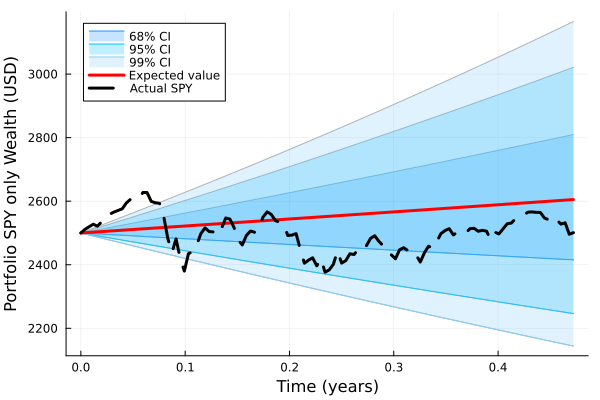

In [71]:
p = plot();
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,3],lw=1,label="",c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,4],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,5],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,6],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,7],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,8],lw=1,label="", c=:gray69)

L68 = wealth_array_SPY[:,3];
U68 = wealth_array_SPY[:,4];
plot!(wealth_array_SPY[:,1], L68, fillrange = U68, fillalpha = 0.25, c = :dodgerblue, label = "68% CI")

L95 = wealth_array_SPY[:,5];
U95 = wealth_array_SPY[:,6];
plot!(wealth_array_SPY[:,1], L95, fillrange = U95, fillalpha = 0.25, c = :deepskyblue, label = "95% CI")

L99 = wealth_array_SPY[:,7];
U99 = wealth_array_SPY[:,8];
plot!(wealth_array_SPY[:,1], L99, fillrange = U99, fillalpha = 0.25, c = :lightskyblue, label = "99% CI")

plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,2],lw=3,label="Expected value", c=:red)
plot!(SPY_actual[:,1], SPY_actual[:,2],lw=3,c=:black,ls=:dash, label="Actual SPY")

xlabel!("Time (years)", fontsize=18)
ylabel!("Portfolio SPY only Wealth (USD)", fontsize=18)

In [ ]:
WFSPY = wealth_array_SPY[end,2] |> x-> round(x,digits=2);
WFSPY_LB = wealth_array_SPY[end,3] |> x-> round(x,digits=2)
WFSPY_UB = wealth_array_SPY[end,4] |> x-> round(x,digits=2)
println("SPY only portfolio should be worth (L,E,U) = ($(WFSPY_LB), $(WFSPY), $(WFSPY_UB)) USD")

SPY only portfolio should be worth (L,E,U) = (2415.48, 2605.17, 2809.76) USD


In [47]:
Δt = (number_of_trading_days/252);
NPV_SPY = -Wₒ + (1/𝒟(risk_free_rate, Δt))*WFSPY
println("The expected NPV for this portfolio is NPV = $(NPV_SPY)")

The expected NPV for this portfolio is NPV = 47.51144771993495
